# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости.<br> 
Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, 
вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Шаг 1. Откроем файл с данными и изучим общую информацию. 

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,7)})


In [35]:
raw_data = pd.read_csv('real_estate_data.csv', delimiter='\t', parse_dates=[3])

In [36]:
raw_data.sample(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
12877,10,5700000.0,50.2,2018-01-22,1,2.75,10.0,25.6,2,NaN,...,11.6,NaN,Сестрорецк,57413.0,34342.0,3.0,170.0,3.0,342.0,25.0
20078,0,5100000.0,55.0,2018-08-16,3,2.55,5.0,40.0,4,NaN,...,6.0,1.0,Пушкин,17236.0,29389.0,1.0,245.0,1.0,928.0,12.0
3187,13,3800000.0,27.0,2016-05-17,1,NaN,14.0,18.0,8,False,...,NaN,2.0,Санкт-Петербург,50348.0,16053.0,0.0,NaN,0.0,NaN,45.0
18230,8,3700000.0,29.5,2018-11-13,1,2.50,9.0,18.2,6,NaN,...,4.1,NaN,Санкт-Петербург,13872.0,11289.0,0.0,NaN,0.0,NaN,4.0
19911,15,3700000.0,32.0,2017-06-09,1,2.65,12.0,15.0,7,NaN,...,7.5,NaN,Санкт-Петербург,9569.0,11687.0,1.0,571.0,1.0,263.0,347.0
8583,16,5500000.0,74.0,2017-10-17,4,NaN,9.0,52.0,7,NaN,...,7.0,NaN,Санкт-Петербург,29965.0,13691.0,0.0,NaN,0.0,NaN,555.0
2632,2,5130593.0,62.4,2015-10-11,2,NaN,24.0,33.1,21,NaN,...,8.2,0.0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,256.0
20847,3,6880000.0,65.0,2017-05-27,3,NaN,5.0,45.0,2,NaN,...,9.0,0.0,Санкт-Петербург,21662.0,2074.0,2.0,235.0,1.0,469.0,131.0
6073,15,5700000.0,54.0,2015-09-30,2,NaN,5.0,33.5,3,NaN,...,8.5,0.0,Санкт-Петербург,27277.0,6828.0,0.0,NaN,1.0,680.0,648.0
943,14,5500000.0,66.0,2018-11-19,2,NaN,25.0,36.0,3,NaN,...,10.0,NaN,Санкт-Петербург,23314.0,11905.0,1.0,909.0,1.0,738.0,30.0


In [37]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

In [38]:
raw_data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [39]:
for column in raw_data.columns:
    if raw_data[column].isnull().sum()>0:
        print(f'Доля пропусков в колонке {column}: {raw_data[column].isnull().sum()*100/len(raw_data[column]):2.2f}%')

Доля пропусков в колонке ceiling_height: 38.80%
Доля пропусков в колонке floors_total: 0.36%
Доля пропусков в колонке living_area: 8.03%
Доля пропусков в колонке is_apartment: 88.29%
Доля пропусков в колонке kitchen_area: 9.61%
Доля пропусков в колонке balcony: 48.61%
Доля пропусков в колонке locality_name: 0.21%
Доля пропусков в колонке airports_nearest: 23.38%
Доля пропусков в колонке cityCenters_nearest: 23.29%
Доля пропусков в колонке parks_around3000: 23.28%
Доля пропусков в колонке parks_nearest: 65.91%
Доля пропусков в колонке ponds_around3000: 23.28%
Доля пропусков в колонке ponds_nearest: 61.56%
Доля пропусков в колонке days_exposition: 13.42%


In [40]:
raw_data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


### Вывод и план действий по столбцам

- **last_price** - переведём в миллионы рублей
- в столбце **ceiling height**: довольно высока доля пропусков, можно заполнить их значением -1 и затем проверить, влияет ли сам факт наличия значения высоты потолка на срок продажи квартиры. Выбросы можно удалить, либо привести к медиане, нужно проверить их количество.
- **floors_total** довольно мало пропусков и нет нереалистичных значений. пропуски можно удалить из набора
- **living_area** - можно заполнить медианой, сгруппировав данные по числу комнат и городам
- **is_apartment** - здесь в основном пропуски и остальные значения - False, что вызвало сомнения. Чтобы убедиться, запустил поиск на сайте с объявлениями по продаже недвижимости - доля апартаментов очень низка. В данном случае, скорее всего неправильно были обработаны данные и на месте пропусков должно быть False.
- **kitchen_area** можно заполнить медианой, сгруппировав по городам и числу комнат
- **balcony** - здесь пропуски скорее всего означают отсутствие балкона и можем заполнить нулями
- **airports_nearest** - имеет смысл перевести в километры и заполнить средним, сгруппировав по населённым пунктам
- **cityCenters_nearest** - аналогично
- **parks и ponds** в задаче не фигурируют, и пропусков довольно много оносительно общего числа строк. столбцы _nearest уберём из набора, _around3000 заполним медианой, сгруппировав по населённым пунктам. 
- **days_exposition** - Пропуски могут означать, что объявление ещё не снято. Нужно посмотреть распределение значений. Переведём в целочисленный формат
- **locality_name** - 49 пропусков - около 0,2% от наших данных; можно безопасно удалить из набора



## Шаг 2. Предобработка данных

In [41]:
#перевод цены в миллионы
raw_data['last_price'] = raw_data['last_price']/1000000

In [42]:
raw_data['first_day_exposition'] = pd.to_datetime(raw_data['first_day_exposition'])
raw_data[['first_day_exposition']].head()


,first_day_exposition
0,2019-03-07
1,2018-12-04
2,2015-08-20
3,2015-07-24
4,2018-06-19


Посмотрим на распределение значений высот потолков и определимся как поступить с аномалиями и пропусками

<AxesSubplot:xlabel='ceiling_height'>

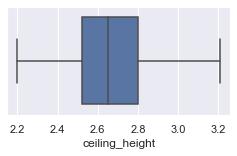

In [43]:
sns.set(rc={'figure.figsize':(4,2)})
sns.boxplot(x= raw_data.ceiling_height, showfliers=False)


Посмотрим сколько у нас аномальных значений относительно общего числа

In [44]:
raw_data[(raw_data['ceiling_height']<2.2)|(raw_data['ceiling_height']>3.2)]['ceiling_height'].count()

831

In [45]:
print(f'Доля аномалий в колонке: {831*100/len(raw_data.ceiling_height):2.2f}%')

Доля аномалий в колонке: 3.51%


аномальными данные значения являются с точки зрения метода расчёта усов для boxplot, стоит рассмотреть также гистограмму

Text(0, 0.5, 'Частота появления')

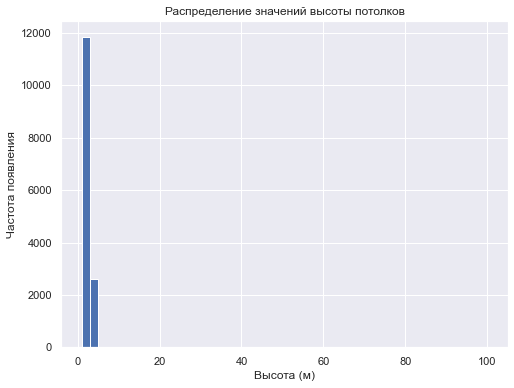

In [46]:
sns.set(rc={'figure.figsize':(8,6)})
hist = raw_data.ceiling_height.hist(bins = 50)
hist.set_title('Распределение значений высоты потолков')
hist.set_xlabel('Высота (м)')
hist.set_ylabel('Частота появления')

Text(0, 0.5, 'Частота появления')

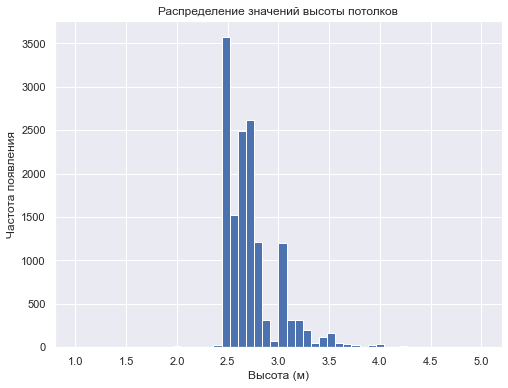

In [47]:
sns.set(rc={'figure.figsize':(8,6)})
hist = raw_data.ceiling_height.hist(bins = 50, range = (1,5))
hist.set_title('Распределение значений высоты потолков')
hist.set_xlabel('Высота (м)')
hist.set_ylabel('Частота появления')

Картина распределения высот потолков выглядит реалистично. Основная часть потолков имеет высоту от 2.5 до 3 метров. Присутствуют выбросы, но на первой гистограмме их не видно из-за редкости. Можно считать все значения больше 4 метров слишком большими, а меньше 2.2 слишком маленькими, проверим сколько таких

In [48]:
raw_data[(raw_data['ceiling_height']<2.2)|(raw_data['ceiling_height']>4)]['ceiling_height'].count()

89

можно удалить слишком явные аномалии из набора, а пропуски заполнить медианой, сгруппировав данные по локации и этажности домов и вынести в отдельный набор

In [49]:
raw_data['ceiling_height'] = (raw_data['ceiling_height'].
                              fillna(raw_data.
                                     groupby(['locality_name', 'floors_total'])['ceiling_height'].
                                     transform('median')))

In [50]:
raw_data = raw_data[((raw_data['ceiling_height']>2.2)&(raw_data['ceiling_height']<4))]

Text(0, 0.5, 'Частота появления')

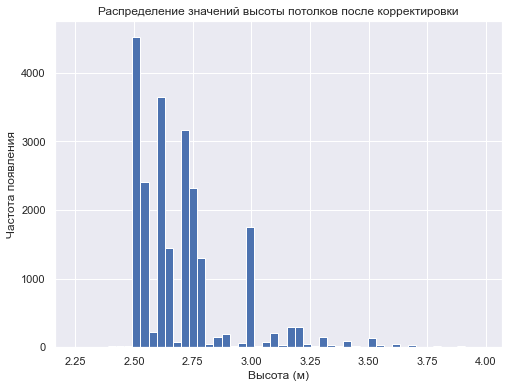

In [51]:
hist = raw_data.ceiling_height.hist(bins = 50)
hist.set_title('Распределение значений высоты потолков после корректировки')
hist.set_xlabel('Высота (м)')
hist.set_ylabel('Частота появления')

In [52]:
raw_data = raw_data.dropna(subset = ['floors_total'], axis = 0)

In [53]:
raw_data = raw_data.fillna(
    {
        "balcony":0,
        "kitchen_area": raw_data.groupby(['locality_name', 'rooms'])['kitchen_area'].transform('median'),
        "living_area": raw_data.groupby(['locality_name', 'rooms'])['living_area'].transform('median'),
        "is_apartment": False,
        "airports_nearest": raw_data.groupby('locality_name')['airports_nearest'].transform('mean'),
        "cityCenters_nearest": raw_data.groupby('locality_name')['cityCenters_nearest'].transform('mean'),
        "parks_around3000" : raw_data.groupby('locality_name')['parks_around3000'].transform('mean'),
        "ponds_around3000" : raw_data.groupby('locality_name')['ponds_around3000'].transform('mean')
    })

In [54]:
raw_data['living_area'].isnull().sum()

29

In [55]:
raw_data['airports_nearest']=(raw_data['airports_nearest']/1000)

In [56]:
raw_data = raw_data.dropna(subset = ['locality_name'], axis = 0)

In [57]:
data = raw_data.drop(['parks_nearest', 'ponds_nearest'], axis = 1)

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23035 entries, 0 to 23698
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23035 non-null  int64         
 1   last_price            23035 non-null  float64       
 2   total_area            23035 non-null  float64       
 3   first_day_exposition  23035 non-null  datetime64[ns]
 4   rooms                 23035 non-null  int64         
 5   ceiling_height        23035 non-null  float64       
 6   floors_total          23035 non-null  float64       
 7   living_area           23006 non-null  float64       
 8   floor                 23035 non-null  int64         
 9   is_apartment          23035 non-null  bool          
 10  studio                23035 non-null  bool          
 11  open_plan             23035 non-null  bool          
 12  kitchen_area          22820 non-null  float64       
 13  balcony         

In [59]:
data.isnull().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area               29
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area             215
balcony                    0
locality_name              0
airports_nearest        5044
cityCenters_nearest     5044
parks_around3000        5044
ponds_around3000        5044
days_exposition         3069
dtype: int64

In [60]:
data = data.dropna(subset=['living_area', 'kitchen_area'], axis = 0)

In [61]:
data[data['airports_nearest'].isna()].isnull().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name              0
airports_nearest        4942
cityCenters_nearest     4942
parks_around3000        4942
ponds_around3000        4942
days_exposition          741
dtype: int64

Оставшиеся пропуски в столбцах с ближайшими аэропортами, парками, центрами городов и водоёмами симметричны. 

In [62]:
data.groupby('locality_name')['airports_nearest'].agg('count').sort_values(ascending = False).head(35)

locality_name
Санкт-Петербург                            15448
посёлок Шушары                               426
Пушкин                                       367
Колпино                                      336
посёлок Парголово                            320
Петергоф                                     200
Сестрорецк                                   177
Красное Село                                 174
Ломоносов                                    133
Кронштадт                                     89
посёлок Металлострой                          62
посёлок Стрельна                              43
Павловск                                      37
Зеленогорск                                   23
посёлок Понтонный                             18
посёлок Молодёжное                             5
посёлок Сапёрный                               5
посёлок Песочный                               4
посёлок Репино                                 3
посёлок Александровская                        1
посёло

Расчёты близости к аэропортам, центру и т.д были проведены только для районов, входящих в Санкт-петербург. Прочие города и посёлки ленобласти не учтены.<br>
Пропуски в данном случае можно оставить, на решение поставленных задач они не повлияют

## Добавление признаков

### Цена квадратного метра

In [63]:
data.reset_index(inplace=True)


In [64]:
data['price_per_meter']=((data['last_price'])/data['total_area'])*1000000
data.head()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,ponds_around3000,days_exposition,price_per_meter
0,0,20,13.000,108.0,2019-03-07,3,2.700,16.0,51.0,8,...,False,25.0,0.0,Санкт-Петербург,18.863,16028.0,1.0,2.0,NaN,120370.370370
1,2,10,5.196,56.0,2015-08-20,2,2.600,5.0,34.3,4,...,False,8.3,0.0,Санкт-Петербург,21.741,13933.0,1.0,2.0,558.0,92785.714286
2,3,0,64.900,159.0,2015-07-24,3,2.600,14.0,45.6,9,...,False,10.0,0.0,Санкт-Петербург,28.098,6800.0,2.0,3.0,424.0,408176.100629
3,4,2,10.000,100.0,2018-06-19,2,3.030,14.0,32.0,13,...,False,41.0,0.0,Санкт-Петербург,31.856,8098.0,2.0,1.0,121.0,100000.000000
4,5,10,2.890,30.4,2018-09-10,1,2.625,12.0,14.4,5,...,False,9.1,0.0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,55.0,95065.789474


In [65]:
data['price_per_meter']= data['price_per_meter'].round(decimals=2)
data.head()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,ponds_around3000,days_exposition,price_per_meter
0,0,20,13.000,108.0,2019-03-07,3,2.700,16.0,51.0,8,...,False,25.0,0.0,Санкт-Петербург,18.863,16028.0,1.0,2.0,NaN,120370.37
1,2,10,5.196,56.0,2015-08-20,2,2.600,5.0,34.3,4,...,False,8.3,0.0,Санкт-Петербург,21.741,13933.0,1.0,2.0,558.0,92785.71
2,3,0,64.900,159.0,2015-07-24,3,2.600,14.0,45.6,9,...,False,10.0,0.0,Санкт-Петербург,28.098,6800.0,2.0,3.0,424.0,408176.10
3,4,2,10.000,100.0,2018-06-19,2,3.030,14.0,32.0,13,...,False,41.0,0.0,Санкт-Петербург,31.856,8098.0,2.0,1.0,121.0,100000.00
4,5,10,2.890,30.4,2018-09-10,1,2.625,12.0,14.4,5,...,False,9.1,0.0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,55.0,95065.79


### День недели, месяц и год публикации

In [66]:
data['day_of_week'] = data['first_day_exposition'].dt.day_of_week
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year
data.head()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,ponds_around3000,days_exposition,price_per_meter,day_of_week,month,year
0,0,20,13.000,108.0,2019-03-07,3,2.700,16.0,51.0,8,...,Санкт-Петербург,18.863,16028.0,1.0,2.0,NaN,120370.37,3,3,2019
1,2,10,5.196,56.0,2015-08-20,2,2.600,5.0,34.3,4,...,Санкт-Петербург,21.741,13933.0,1.0,2.0,558.0,92785.71,3,8,2015
2,3,0,64.900,159.0,2015-07-24,3,2.600,14.0,45.6,9,...,Санкт-Петербург,28.098,6800.0,2.0,3.0,424.0,408176.10,4,7,2015
3,4,2,10.000,100.0,2018-06-19,2,3.030,14.0,32.0,13,...,Санкт-Петербург,31.856,8098.0,2.0,1.0,121.0,100000.00,1,6,2018
4,5,10,2.890,30.4,2018-09-10,1,2.625,12.0,14.4,5,...,городской посёлок Янино-1,NaN,NaN,NaN,NaN,55.0,95065.79,0,9,2018


### Категоризация по этажам: первый, последний, другой

Также добавим категории представленные в числовом виде, так как выбранный для построения графиков модуль некорректно работает со строковыми данными

In [67]:
def floor_type(row):
    if row['floor']==1:
        return 'первый'
    elif row['floor']==row['floors_total']:
        return 'последний'
    else:
        return 'другой'
def floor_type_cat(row):
    if row['floor']==1:
        return 1
    elif row['floor']==row['floors_total']:
        return 2
    else:
        return 3

In [68]:
data['floor_group'] = data.apply(floor_type, axis = 1)
data['floor_group_cat'] = data.apply(floor_type_cat, axis = 1)

In [69]:
data.floor_group.unique()

array(['другой', 'последний', 'первый'], dtype=object)

### Соотношение жилой и общей площади, кухни и общей площади

In [70]:
data['living_total_ratio'] = data['living_area']/data['total_area']
data['kitchen_total_ratio'] = data['kitchen_area']/data['total_area']
data.head()

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,ponds_around3000,days_exposition,price_per_meter,day_of_week,month,year,floor_group,floor_group_cat,living_total_ratio,kitchen_total_ratio
0,0,20,13.000,108.0,2019-03-07,3,2.700,16.0,51.0,8,...,2.0,NaN,120370.37,3,3,2019,другой,3,0.472222,0.231481
1,2,10,5.196,56.0,2015-08-20,2,2.600,5.0,34.3,4,...,2.0,558.0,92785.71,3,8,2015,другой,3,0.612500,0.148214
2,3,0,64.900,159.0,2015-07-24,3,2.600,14.0,45.6,9,...,3.0,424.0,408176.10,4,7,2015,другой,3,0.286792,0.062893
3,4,2,10.000,100.0,2018-06-19,2,3.030,14.0,32.0,13,...,1.0,121.0,100000.00,1,6,2018,другой,3,0.320000,0.410000
4,5,10,2.890,30.4,2018-09-10,1,2.625,12.0,14.4,5,...,NaN,55.0,95065.79,0,9,2018,другой,3,0.473684,0.299342


## Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

### Изучите следующие параметры: площадь, цена, число комнат, высота потолков. Постройте гистограммы для каждого параметра.

In [71]:
data[['total_area', 'last_price', 'rooms', 'ceiling_height']].describe()

,total_area,last_price,rooms,ceiling_height
count,22815.000000,22815.000000,22815.000000,22815.000000
mean,60.494361,6.568248,2.087705,2.702750
std,35.028772,10.818897,1.065027,0.218264
min,12.000000,0.012190,1.000000,2.250000
25%,40.200000,3.500000,1.000000,2.550000
50%,52.000000,4.700000,2.000000,2.650000
75%,70.000000,6.800000,3.000000,2.750000
max,900.000000,763.000000,19.000000,3.980000


В столбце с ценой наиболее сильна разница между медианой и средним значением, что говорит нам о значительных выбросах. <br>Также есть заметная разница между данными показателями в столбце с площадью

#### - Площадь
построим диаграмму размаха и гистограмму

Text(0.5, 1.0, 'Диаграмма размаха значений общей площади')

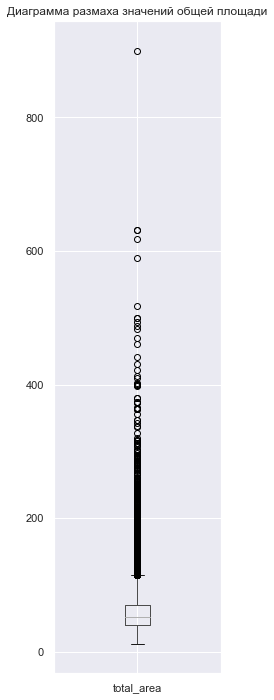

In [72]:
boxplot = data.boxplot('total_area', figsize = (3, 12))
boxplot.set_title('Диаграмма размаха значений общей площади')



Text(0.5, 1.0, 'Распределение значений площади')

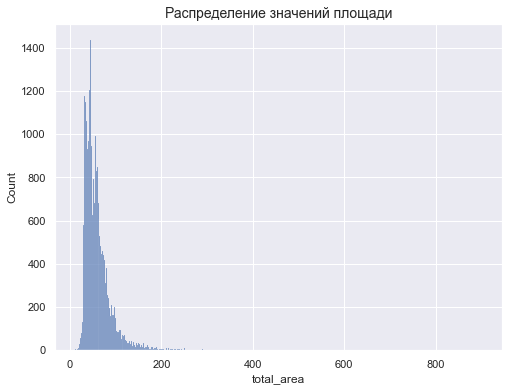

In [73]:
sns.histplot(data['total_area'])
plt.title("Распределение значений площади", size=14)

далее построим гистограмму, но без учёта выбросов
- метод get_ydata позволяет взять точные значения границ "усов"

In [74]:
boxplot_data = plt.boxplot(data['total_area'], autorange=True)
plt.close()
whiskers_area = [item.get_ydata() for item in boxplot_data['whiskers']]
whiskers_area

[array([40.2, 12. ]), array([ 70. , 114.6])]

In [75]:
total_area_good = data.query('total_area < @whiskers_area[1][1] and total_area > @whiskers_area[0][1]')[['total_area']]

Text(0.5, 1.0, 'Распределение значений площади после корректировки')

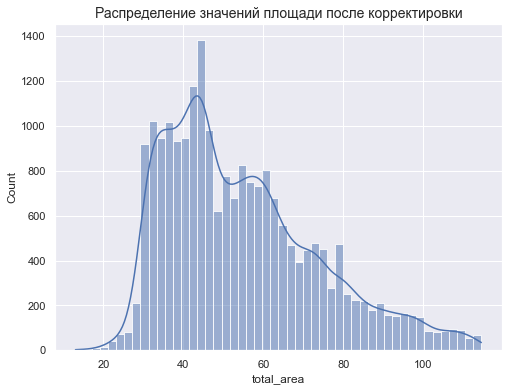

In [76]:
sns.histplot(total_area_good['total_area'], bins = 50, kde=True)
plt.title("Распределение значений площади после корректировки", size=14)

Далее повторим те же шаги для остальных пунктов

#### - Цена

Text(0.5, 1.0, 'Диаграмма размаха значений цены')

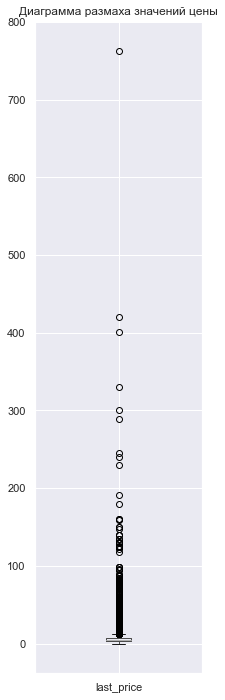

In [77]:
boxplot = data.boxplot('last_price', figsize = (3, 12))
boxplot.set_title('Диаграмма размаха значений цены')

Text(0.5, 1.0, 'Распределение значений цен на квартиры')

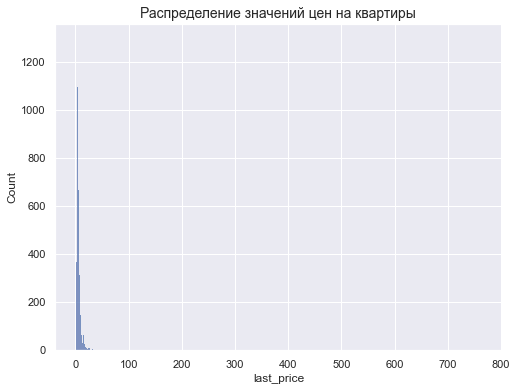

In [78]:
sns.histplot(data['last_price'])
plt.title("Распределение значений цен на квартиры", size=14)

Довольно много выбросов с повышенной ценой квартиры, которые искажают гистограмму и при этом их не видно

In [79]:
boxplot_data = plt.boxplot(data['last_price'])
plt.close()
whiskers_price = [item.get_ydata() for item in boxplot_data['whiskers']]
whiskers_price

[array([3.5    , 0.01219]), array([ 6.8 , 11.75])]

In [80]:
last_price_good = data.query('last_price < @whiskers_price[1][1] and last_price > @whiskers_price[0][1]')[['last_price']]

Text(0.5, 1.0, 'Распределение значений цен после корректировки')

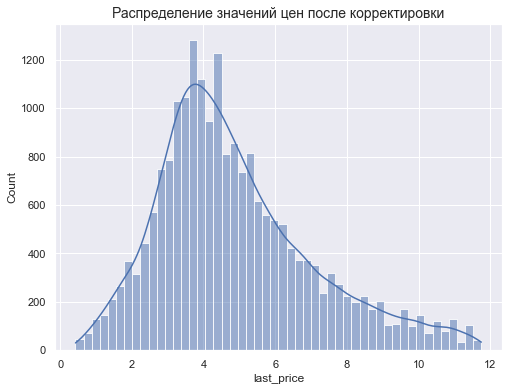

In [81]:
sns.histplot(last_price_good['last_price'], bins = 50, kde=True)
plt.title("Распределение значений цен после корректировки", size=14)

Распределение цен близко к нормальному с наибольшей концентрацией в районе около 4млн. руб.

#### - Число комнат

Text(0.5, 1.0, 'Диаграмма размаха числа комнат')

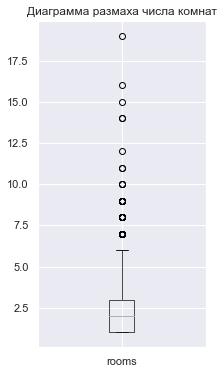

In [82]:
boxplot = data.boxplot('rooms', figsize=(3,6))
boxplot.set_title('Диаграмма размаха числа комнат')

Text(0.5, 1.0, 'Распределение числа комнат')

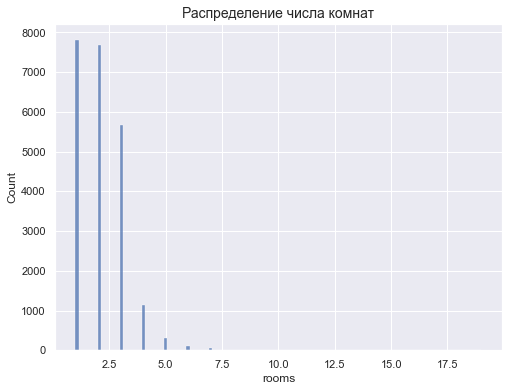

In [83]:
sns.histplot(data['rooms'])
plt.title("Распределение числа комнат", size=14)

In [84]:
boxplot_data = plt.boxplot(data['rooms'])
plt.close()
whiskers_rooms = [item.get_ydata() for item in boxplot_data['whiskers']]
whiskers_rooms

[array([1., 1.]), array([3., 6.])]

In [85]:
rooms_good = data.query('rooms < @whiskers_rooms[1][1] and rooms > @whiskers_rooms[0][1]')[['rooms']]

Text(0.5, 1.0, 'Распределение числа комнат после корректировки')

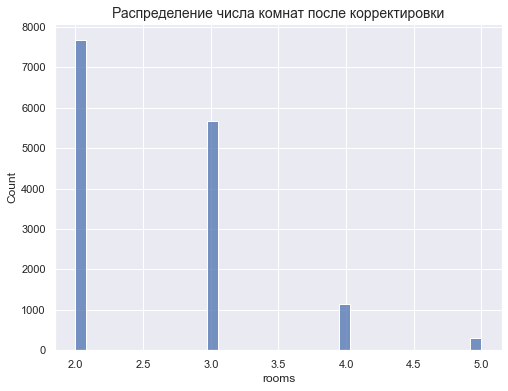

In [86]:
sns.histplot(rooms_good['rooms'])
plt.title("Распределение числа комнат после корректировки", size=14)

#### - Высота потолков

Text(0.5, 1.0, 'Диаграмма размаха значений высоты потолков')

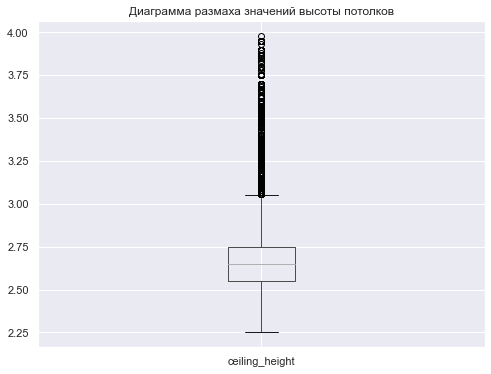

In [87]:
boxplot = data.boxplot('ceiling_height')
boxplot.set_title('Диаграмма размаха значений высоты потолков')

Text(0.5, 1.0, 'Распределение значений высоты потолка')

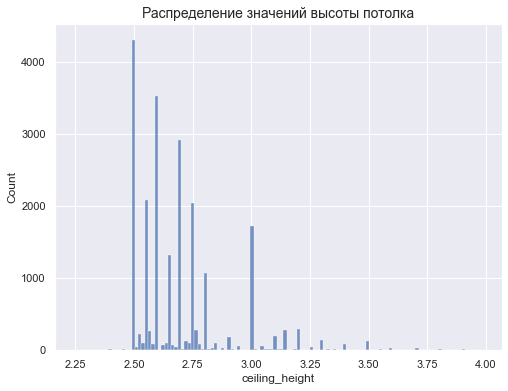

In [88]:
sns.histplot(data['ceiling_height'])
plt.title("Распределение значений высоты потолка", size=14)

In [89]:
boxplot_data = plt.boxplot(data['ceiling_height'])
plt.close()
whiskers_ceiling = [item.get_ydata() for item in boxplot_data['whiskers']]
whiskers_ceiling

[array([2.55, 2.25]), array([2.75, 3.05])]

Выбросы были обработаны на более раннем этапе, поэтому ничего не меняем

### Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

Text(0.5, 1.0, 'Диаграмма размаха времени продажи квартир')

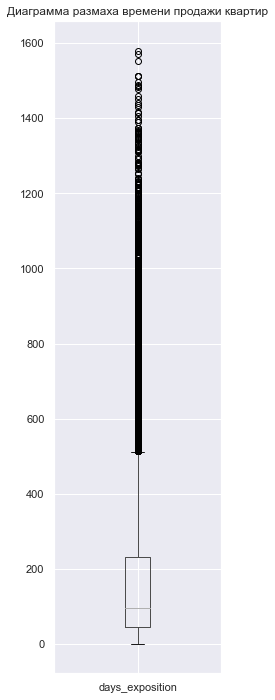

In [90]:
boxplot = data.boxplot('days_exposition', figsize = (3, 12))
boxplot.set_title('Диаграмма размаха времени продажи квартир')

In [91]:
data['days_exposition'].describe()

count    19765.000000
mean       181.773286
std        220.533321
min          1.000000
25%         45.000000
50%         96.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

Для предсказания цен нам интересны только успешно проданные квартиры, поэтому, удалим строки с пропусками в **days_exposition**, считая их всё еще актуальными объявлениями

In [92]:
exposition = data.dropna(subset = ['days_exposition'])[['days_exposition']]
exposition

,days_exposition
1,558.0
2,424.0
3,121.0
4,55.0
5,155.0
...,...
22808,519.0
22809,413.0
22810,239.0
22812,45.0


In [93]:
boxplot_data = plt.boxplot(exposition)
plt.close()
whiskers_expo = [item.get_ydata() for item in boxplot_data['whiskers']]
whiskers_expo

[array([45.,  1.]), array([232., 512.])]

Text(0.5, 1.0, 'Распределение значений времени продажи квартир без учёта выбросов')

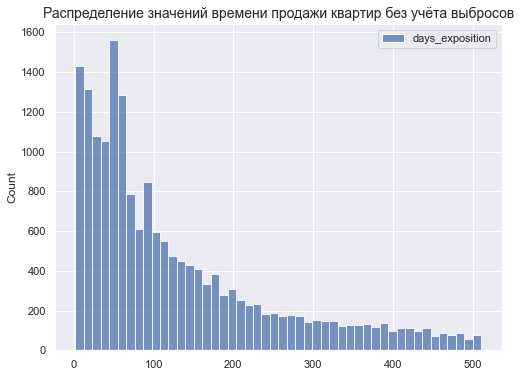

In [94]:
sns.histplot(exposition.query('days_exposition > @whiskers_expo[0][1] and days_exposition <@whiskers_expo[1][1]'))
plt.title("Распределение значений времени продажи квартир без учёта выбросов", size=14)

Среднее время продажи - 181 день, тогда как медиана - 95 дней. <br>
На среднее время значительно повлияли выбросы, поэтому обычным временем продажи можно считать медианное значение, либо диапазон от 25% до 75% - 45-231 день. <br>
Верхний "ус" - 512 дней, всё что больше - можно считать аномально большим сроком продажи. <br>
Что касается аномально малых сроков, в данном случае учитывается время, которое объявление провисело на сайте, и факт продажи не подтверждается. Тогда вполне вероятно, что покупатель может найтись за 1-3 дня. Но скорее всего, человек, разместивший объявление, по каким-то причинам передумал либо снял объявление для последующей доработки. <br>
Полноценная же продажа кваритры с оформлением всех необходимых документов за один день невозможна. <br>
Посмотрим, какую долю от общего количества составляют объявления снятые за 1-7 дней <br>

In [95]:
exposition.query('days_exposition>=1 and days_exposition <=7').count()*100/exposition.shape[0]

days_exposition    4.108272
dtype: float64

Удаление 4% процентов оставит нам достаточное количество данных для работы

In [96]:
exposition_good = exposition.query('days_exposition >7')

Далее вновь объединим получившиеся срезы и данные из основного набора

In [97]:
last_price_good

,last_price
1,5.196
3,10.000
4,2.890
5,3.700
6,7.915
...,...
22810,4.600
22811,9.700
22812,3.100
22813,11.475


In [98]:
data_good = exposition_good.join(last_price_good)
data_good = data_good.join(total_area_good)
data_good = data_good.join(rooms_good)
data_good = data_good.join(data[['ceiling_height',
                                 'cityCenters_nearest',
                                 'floor_group',
                                 'floor_group_cat',
                                 'day_of_week',
                                 'month',
                                 'year',
                                 'locality_name',
                                 'price_per_meter']])

In [99]:
data_good

,days_exposition,last_price,total_area,rooms,ceiling_height,cityCenters_nearest,floor_group,floor_group_cat,day_of_week,month,year,locality_name,price_per_meter
1,558.0,5.196,56.00,2.0,2.600,13933.0,другой,3,3,8,2015,Санкт-Петербург,92785.71
2,424.0,NaN,NaN,3.0,2.600,6800.0,другой,3,4,7,2015,Санкт-Петербург,408176.10
3,121.0,10.000,100.00,2.0,3.030,8098.0,другой,3,1,6,2018,Санкт-Петербург,100000.00
4,55.0,2.890,30.40,NaN,2.625,NaN,другой,3,0,9,2018,городской посёлок Янино-1,95065.79
5,155.0,3.700,37.30,NaN,2.600,19143.0,другой,3,3,11,2017,посёлок Парголово,99195.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22808,519.0,9.470,72.90,2.0,2.750,4489.0,другой,3,3,10,2016,Санкт-Петербург,129903.98
22809,413.0,1.350,30.00,NaN,2.550,NaN,другой,3,4,7,2017,Тихвин,45000.00
22810,239.0,4.600,62.40,3.0,2.600,34104.0,другой,3,4,8,2016,Петергоф,73717.95
22812,45.0,3.100,59.00,3.0,2.500,NaN,другой,3,0,1,2018,Тосно,52542.37


In [100]:
data_good.isna().sum()

days_exposition           0
last_price             1463
total_area              869
rooms                  6872
ceiling_height            0
cityCenters_nearest    4056
floor_group               0
floor_group_cat           0
day_of_week               0
month                     0
year                      0
locality_name             0
price_per_meter           0
dtype: int64

Снова появились пропуски, но уже из-за разного размера срезов

### Какие факторы больше всего влияют на стоимость квартиры?

Построим графики рассеяния для выявления взаимосвязи между Ценой и следующими показателями:
- общая площадь
- высота потолков
- количество комнат
- близость к центру
- этаж, первый, последний или другой (1 2 и 3 соответственно)

Для этого используем функцию regplot модуля seaborn, строящую диаграмму рассеяния с линией регрессии

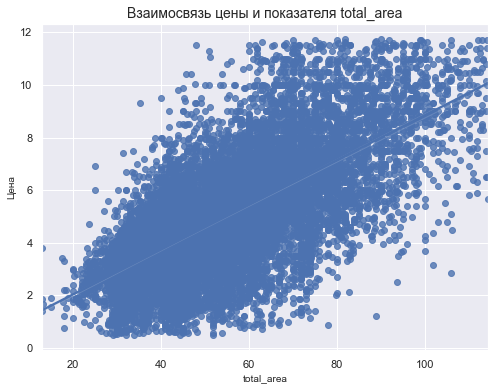

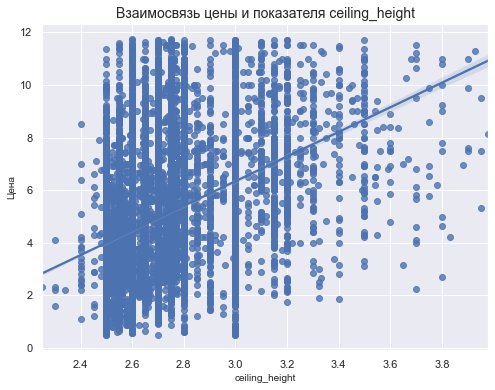

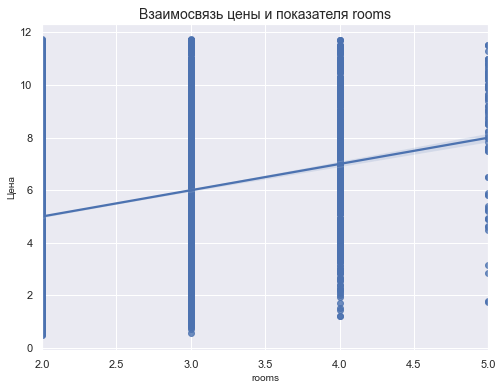

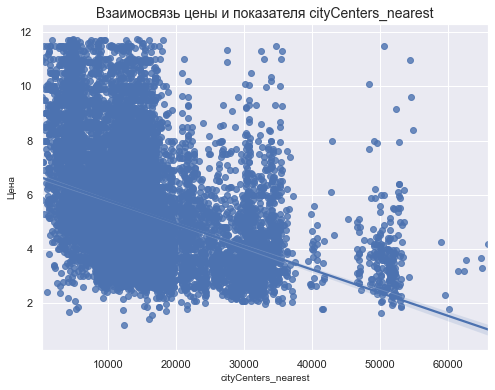

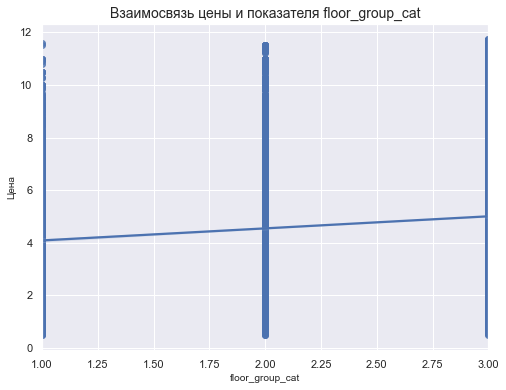

In [101]:
for item in ['total_area', 'ceiling_height', 'rooms', 'cityCenters_nearest', 'floor_group_cat']:
    label = 'Взаимосвязь цены и показателя ' + str(item)
    sns.regplot(data=data_good,
                   x=item,
                   y='last_price',
                dropna = True,
                )
    plt.xlabel(item, size=10)
    plt.ylabel('Цена', size=10)
    plt.title(label, size=14)
    plt.show()

Возьмём также срез таблицы корреляции, показывающий связь между ценой и всеми имеющимися показателями

In [102]:
data_good.corr()[1:2]

,days_exposition,last_price,total_area,rooms,ceiling_height,cityCenters_nearest,floor_group_cat,day_of_week,month,year,price_per_meter
last_price,0.077561,1.0,0.706163,0.283583,0.409835,-0.357829,0.150011,-0.007184,0.0116,-0.027891,0.594073


Для выявления зависимости между ценой и днем недели месяцем и годом корректнее будет смотреть на динамику средних значений цен за каждый выбранный промежуток. Также возьмём минимальные, максимальные и медианы

Text(0, 0.5, 'Цена')

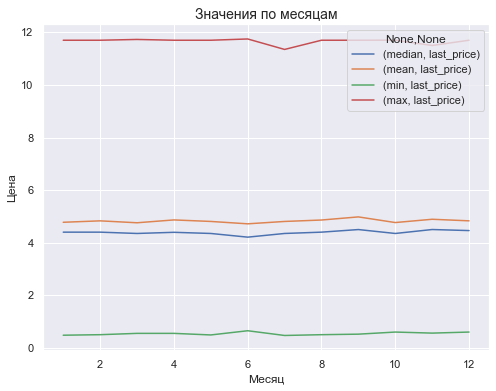

In [103]:
data_good.pivot_table(index='month', values = ['last_price'], aggfunc = ['median', 'mean', 'min', 'max']).plot()
plt.title('Значения по месяцам',size = 14)
plt.xlabel('Месяц')
plt.ylabel('Цена')

Text(0, 0.5, 'Цена')

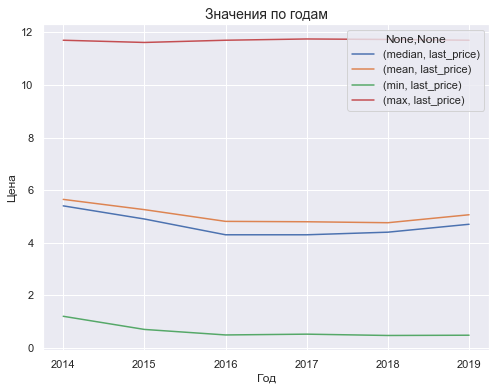

In [104]:
data_good.pivot_table(index='year', values = ['last_price'], aggfunc = ['median', 'mean', 'min', 'max']).plot()
plt.title('Значения по годам',size = 14)
plt.xlabel('Год')
plt.ylabel('Цена')

Text(0, 0.5, 'Цена')

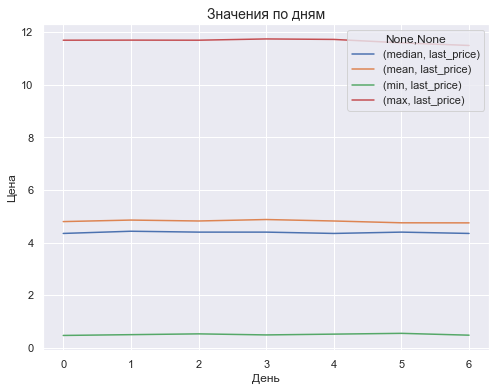

In [105]:
data_good.pivot_table(index='day_of_week', values = ['last_price'], aggfunc = ['median', 'mean', 'min', 'max']).plot()
plt.title('Значения по дням',size = 14)
plt.xlabel('День')
plt.ylabel('Цена')

- Цена наиболее явно растёт с увеличением площади и количества комнат (большая площадь позволяет сделать больше комнат, но попадаются и маленькие многокомнатные квартиры) Люди предпочитают, по-возможности, варианты попросторнее, поэтому вторая взаимосвязь выражена слабее. 
- Ещё слабее выражена взаимосвязь между ценой и высотой потолков, но варианты с высокими потолками в целом дороже
- Цена падает с удалением от центра города
- Первый и последний этажи менее предпочтительные для людей варианты по сравнению с остальными и цены на них обычно меньше.
- Стоимость почти никак не связана с днём недели или месяцем размещения, но прослеживается зависимость если брать года.

### Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите среди них населённые пункты с самой высокой и низкой стоимостью жилья.

In [106]:
data_cities = data_good.pivot_table(index = 'locality_name', values = ['price_per_meter'], aggfunc=['count','min', 'mean', 'median', 'max'])
data_cities.columns = ['count_of_entries', 'min_price', 'avg_price', 'median_price', 'max_price']
#Создаём список с 10 городами с наибольшим количеством объявлений
top10_cities = data_cities.sort_values('count_of_entries', ascending=False).head(10)

In [107]:
#Полученный список выводим, отсортировав по средней цене квадратного метра
top10_cities.sort_values('avg_price', ascending = False)

,count_of_entries,min_price,avg_price,median_price,max_price
locality_name,,,,,
Санкт-Петербург,12821,111.83,112174.330921,102897.100,1907500.00
Пушкин,290,59836.07,101210.877655,97725.710,256521.74
деревня Кудрово,272,54160.35,92159.916176,91499.170,142857.14
посёлок Парголово,278,48405.47,89329.312662,91145.230,138522.43
посёлок Мурино,459,51460.48,85319.585926,84726.220,138580.25
посёлок Шушары,382,50000.00,77855.335445,76220.395,126666.67
Колпино,291,47957.37,74582.418832,73728.810,125000.00
Всеволожск,322,31400.00,68585.037453,65789.470,640422.35
Гатчина,254,10507.25,67810.829370,67180.705,105818.18


- Из 10 городов с наибольшим количеством объявлений жильё дешевле всего в Выборге, и дороже всего в Санкт-Петербурге.

### Выяснить, какая область входит в центр Санкт-Петербурга.

In [108]:
spb_data = data_good.query('locality_name == "Санкт-Петербург"')
spb_data = spb_data.reset_index(drop=True)


In [109]:
spb_data['cityCenters_nearest'] = spb_data['cityCenters_nearest']/1000

In [110]:
spb_data['cityCenters_nearest'] = spb_data['cityCenters_nearest'].astype('int')

In [111]:
spb_data

,days_exposition,last_price,total_area,rooms,ceiling_height,cityCenters_nearest,floor_group,floor_group_cat,day_of_week,month,year,locality_name,price_per_meter
0,558.0,5.196,56.00,2.0,2.60,13,другой,3,3,8,2015,Санкт-Петербург,92785.71
1,424.0,NaN,NaN,3.0,2.60,6,другой,3,4,7,2015,Санкт-Петербург,408176.10
2,121.0,10.000,100.00,2.0,3.03,8,другой,3,1,6,2018,Санкт-Петербург,100000.00
3,289.0,5.400,61.00,3.0,2.50,15,другой,3,6,2,2017,Санкт-Петербург,88524.59
4,137.0,5.050,39.60,NaN,2.67,13,другой,3,3,11,2017,Санкт-Петербург,127525.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12816,23.0,9.200,101.00,3.0,3.05,14,другой,3,0,4,2019,Санкт-Петербург,91089.11
12817,29.0,3.550,35.30,NaN,2.86,16,другой,3,2,2,2018,Санкт-Петербург,100566.57
12818,15.0,5.500,52.00,2.0,2.60,6,другой,3,3,7,2018,Санкт-Петербург,105769.23
12819,519.0,9.470,72.90,2.0,2.75,4,другой,3,3,10,2016,Санкт-Петербург,129903.98


In [112]:
price_per_km = spb_data.groupby(['cityCenters_nearest'])[['last_price']].mean()

In [113]:
price_per_km

,last_price
cityCenters_nearest,
0,8.413971
1,7.930432
2,7.541223
3,7.281200
4,7.638614
5,7.323903
6,6.670317
7,6.644585
8,6.195891


Text(0.5, 1.0, 'Влияние расстояния от центра города на цены квартир')

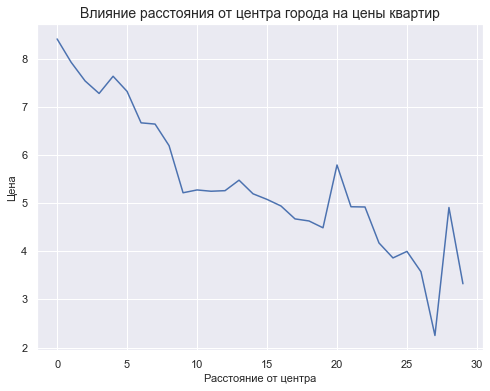

In [114]:
sns.lineplot(x=price_per_km.index, y=price_per_km['last_price'], )
plt.xlabel("Расстояние от центра", size=11)
plt.ylabel("Цена", size=11)
plt.title("Влияние расстояния от центра города на цены квартир", size=14)

- После девятого километра темп падения цены значительно снижается, зетем резкий скачок на двадцатом километре и стремительное падение до 27-го с последующим резким ростом. 
Таким образом, центральная зона имеет радиус около 9км.
- Последующие скачки могут быть обусловлены сокращением количества объявлений с удалением от центра и возврастающей "шумностью" данных


In [348]:
spb_data.groupby(['cityCenters_nearest'])[['last_price']].count()

,last_price
cityCenters_nearest,
0,35
1,111
2,161
3,289
4,473
5,423
6,268
7,257
8,456


- Предположение подтвердилось, а также видим наибольшую плотность размещённых объявлений между 10 и 16 км. 

### Проанализируйте данные в центре

In [349]:
spb_center = spb_data[spb_data['cityCenters_nearest']<9]
spb_center.describe()

,days_exposition,last_price,total_area,rooms,ceiling_height,cityCenters_nearest,floor_group_cat,day_of_week,month,year,price_per_meter
count,3480.000000,2473.000000,2870.000000,2756.000000,3480.000000,3480.000000,3480.000000,3480.000000,3480.000000,3480.000000,3.480000e+03
mean,244.669540,7.086484,67.056620,2.877358,2.921664,4.817529,2.626724,2.552011,6.604885,2017.005747,1.369041e+05
std,270.599294,2.205371,22.362769,0.886386,0.300620,2.110291,0.664484,1.725365,3.444535,1.044000,8.245883e+04
min,8.000000,1.686000,13.000000,2.000000,2.400000,0.000000,1.000000,0.000000,1.000000,2014.000000,1.534527e+04
25%,60.000000,5.400000,47.925000,2.000000,2.650000,3.000000,2.000000,1.000000,3.000000,2016.000000,9.793814e+04
50%,139.000000,6.900000,65.400000,3.000000,3.000000,5.000000,3.000000,3.000000,7.000000,2017.000000,1.193221e+05
75%,337.000000,8.721680,84.185000,3.000000,3.100000,7.000000,3.000000,4.000000,10.000000,2018.000000,1.480865e+05
max,1572.000000,11.730000,114.550000,5.000000,3.980000,8.000000,3.000000,6.000000,12.000000,2019.000000,1.907500e+06


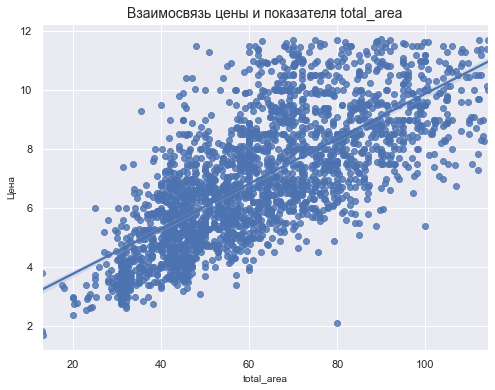

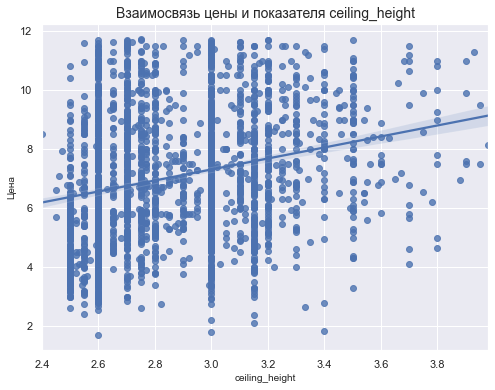

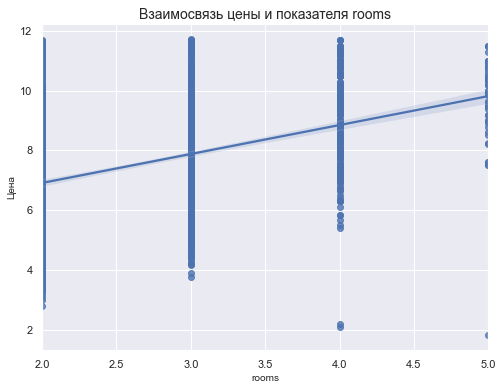

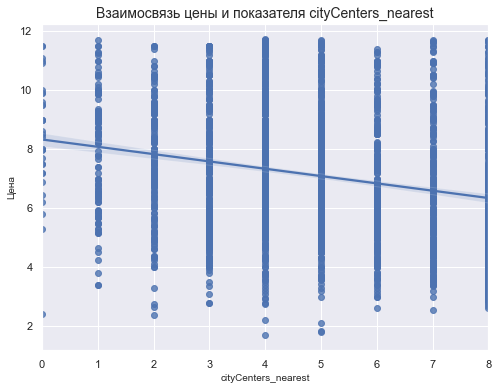

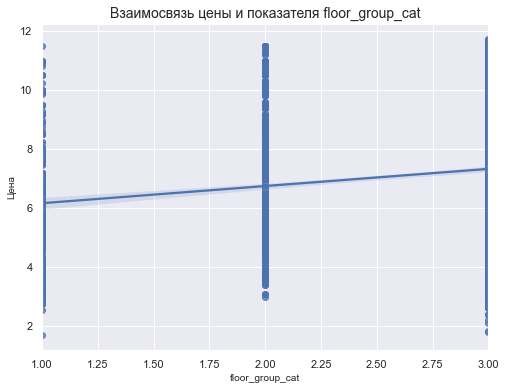

In [350]:
for item in ['total_area', 'ceiling_height', 'rooms', 'cityCenters_nearest', 'floor_group_cat']:
    label = 'Взаимосвязь цены и показателя ' + str(item)
    sns.regplot(data=spb_center,
                   x=item,
                   y='last_price',
                dropna = True,
                )
    plt.xlabel(item, size=10)
    plt.ylabel('Цена', size=10)
    plt.title(label, size=14)
    plt.show()

Построим таблицу корреляции для данных по Санкт-Петербургу, ещё раз выведем таблицу корреляции из прошлого пункта, а также возьмём срез для данных, исключая Санкт-Петербург

In [351]:
spb_center.corr()[1:2]

,days_exposition,last_price,total_area,rooms,ceiling_height,cityCenters_nearest,floor_group_cat,day_of_week,month,year,price_per_meter
last_price,0.159829,1.0,0.720771,0.359516,0.243211,-0.238375,0.186125,0.034154,0.00571,-0.059161,0.241556


<div class="alert alert-success">
<b>Комментарий ревьюера:</b>
    

В том числе можно было построить матрицу корреляции между нужными нам переменными.
    
И визуализировать её с помощью метода `heatmap` из библиотеки `seaborn`.
    
</div>

In [352]:
data_good.corr()[1:2]

,days_exposition,last_price,total_area,rooms,ceiling_height,cityCenters_nearest,floor_group_cat,day_of_week,month,year,price_per_meter
last_price,0.077561,1.0,0.706163,0.283583,0.409835,-0.357829,0.150011,-0.007184,0.0116,-0.027891,0.594073


In [353]:
data_good.query('locality_name !="Санкт-Петербург"').corr()[1:2]

,days_exposition,last_price,total_area,rooms,ceiling_height,cityCenters_nearest,floor_group_cat,day_of_week,month,year,price_per_meter
last_price,0.021482,1.0,0.637657,0.27914,0.276509,-0.051016,0.148364,-0.031687,0.017329,-0.032743,0.613746


Text(0, 0.5, 'Цена')

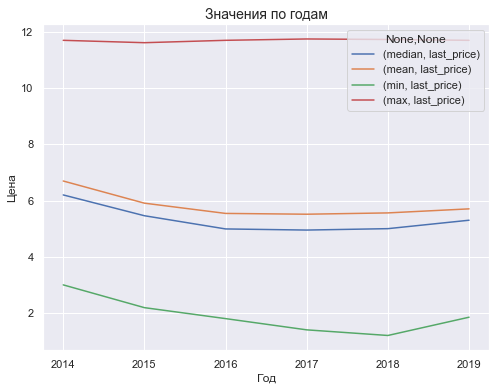

In [354]:
spb_data.pivot_table(index='year', values = ['last_price'], aggfunc = ['median', 'mean', 'min', 'max']).plot()
plt.title('Значения по годам',size = 14)
plt.xlabel('Год')
plt.ylabel('Цена')

Взаимосвязь Цены с площадью и количеством комнат в Петербурге выражена сильнее, чем в остальных населённых пунктах, с потолками - наоборот.
Динамика роста средней цены по годам после 2018 чуть ниже в Петербурге чем в общем наборе данных

## Шаг 5. Общий вывод

Для более точной работы системы определения цен будет важно учитывать специфику населённых пунктов и областей, в которых размещаются объявления. Возможно, иметь дело с несколькими отдельными моделями для крупных городов и пригородов.